In [1]:
! pip install gdown==3.13.0 --quiet
! pip install spacy==3.0.6 --quiet
! pip install tweet-preprocessor --quiet
! pip install pytorch-lightning --quiet
! pip install omegaconf --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 12.8MB 239kB/s 
     |████████████████████████████████| 460kB 52.1MB/s 
     |████████████████████████████████| 1.1MB 40.8MB/s 
     |████████████████████████████████| 51kB 3.3MB/s 
     |████████████████████████████████| 9.1MB 30.7MB/s 
     |████████████████████████████████| 122kB 57.0MB/s 
     |████████████████████████████████| 808kB 7.4MB/s 
     |████████████████████████████████| 112kB 26.8MB/s 
     |████████████████████████████████| 829kB 22.4MB/s 
     |████████████████████████████████| 645kB 37.4MB/s 
     |████████████████████████████████| 10.6MB 40.4MB/s 
     |████████████████████████████████| 276kB 52.0MB/s 
     |████████████████████████████████| 1.3MB 49.0MB/s 
     |████████████████████████████████| 143kB 57.4MB/s 
     |████████████████████████████████| 296kB 49.8MB/s 
ERROR: tensorflow 2.5.0 has requirem

In [2]:
! python -m spacy download en_core_web_sm

2021-06-10 04:04:59.802511: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 13.7MB 220kB/s 
  Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
import torch
import torchtext
import gdown

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy

from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

from torchtext.utils import download_from_url, extract_archive
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import torchtext.experimental.functional as text_f

import torchtext.experimental.functional as text_f

from pathlib import Path
from functools import partial

import pandas as pd
import preprocessor as p

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import *

import random

from tqdm.auto import tqdm
from omegaconf import OmegaConf

from IPython.display import display, HTML

sns.set()

In [4]:
class TweetsDataset(Dataset):
    """
    """

    URL = 'https://drive.google.com/uc?id=1gCEb9iRVYet15O4Tqvrj9Fjq9lVbSEQg'
    OUTPUT = 'tweets_cleaned.csv'
 

    def __init__(self, root, vocab=None, vectors=None, text_transforms=None, label_transforms=None, ngrams=1):
        """Initiate text-classification dataset.
        Args:
            vocab: Vocabulary object used for dataset.
        """

        super(self.__class__, self).__init__()

        # if split not in ['train', 'test']:
        #     raise ValueError(f'split must be either ["train", "test"] unknown split {split}')

        if vocab and vectors:
            raise ValueError(f'both vocab and vectors cannot be provided')

        self.vocab = vocab
        self.vectors = vectors

        gdown.cached_download(self.URL, Path(root) / self.OUTPUT)

        self.generate_tweet_dataset(Path(root) / self.OUTPUT)

        tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

        # the text transform can only work at the sentence level
        # the rest of tokenization and vocab is done by this class
        self.text_transform = text_f.sequential_transforms(tokenizer, text_f.ngrams_func(ngrams))
        self.tokenizer_transform = self.text_transform

        self.vocab_transforms = text_f.sequential_transforms()
        self.vector_transforms = text_f.sequential_transforms()

        def build_vocab(data, transforms):
            def apply_transforms(data):
                for line in data:
                    yield transforms(line)
            return build_vocab_from_iterator(apply_transforms(data), len(data))

        if self.vectors:
            self.vector_transforms = text_f.sequential_transforms(
                partial(vectors.get_vecs_by_tokens, lower_case_backup=True)
            )
        elif self.vocab is None:
            # vocab is always built on the train dataset
            self.vocab = build_vocab(self.dataset["tweets_cleaned"], self.text_transform)
    
        if self.vocab:
            self.vocab_transforms = text_f.sequential_transforms(
                text_f.vocab_func(self.vocab), text_f.totensor(dtype=torch.long)
            )

        if text_transforms is not None:
            self.text_transform = text_f.sequential_transforms(
                self.text_transform, text_transforms, self.vocab_transforms, self.vector_transforms 
            )
        else:
            self.text_transform = text_f.sequential_transforms(
                self.text_transform, self.vocab_transforms, self.vector_transforms
            )

        self.label_transform = text_f.sequential_transforms(text_f.totensor(dtype=torch.long))

    def generate_tweet_dataset(self, dataset_file):
        self.dataset = pd.read_csv(dataset_file)

    def __getitem__(self, idx):
        text = self.text_transform(self.dataset['tweets_cleaned'].iloc[idx])
        label = self.label_transform(self.dataset['labels'].iloc[idx])
        return label, text, (self.dataset['tweets'].iloc[idx], self.dataset['tweets_cleaned'].iloc[idx])

    def __len__(self):
        return len(self.dataset)

    @staticmethod
    def get_labels():
        return ['Negative', 'Positive', 'Neutral']

    def get_vocab(self):
        return self.vocab

    def get_vectors(self):
        return self.vectors

    def collator_fn(self, raw_texts=False):
        def collate_fn(batch):
            
            labels, sequences, raw_texts = zip(*batch)

            labels = torch.stack(labels)

            lengths = torch.LongTensor([len(sequence) for sequence in sequences])

            # print('before padding: ', sequences[40])

            if not self.vectors:
                pad_idx = self.get_vocab()['<pad>']
                sequences = torch.nn.utils.rnn.pad_sequence(sequences, 
                                                            padding_value = pad_idx,
                                                            batch_first=True
                                                            )
            # print('after padding: ', sequences[40])
            if raw_texts:
                return labels, sequences, lengths, raw_texts
            else:
                return labels, sequences, lengths
        
        return collate_fn

In [5]:
class TweetsDataModule(pl.LightningDataModule):
    """
    DataModule for Tweets, train, val, test splits and transforms
    """

    name = "tweets"

    def __init__(
        self,
        data_dir: str = '.',
        val_split: int = 300,
        num_workers: int = 2,
        batch_size: int = 128,
        *args,
        **kwargs,
    ):
        """
        Args:
            data_dir: where to save/load the data
            val_split: how many of the training images to use for the validation split
            num_workers: how many workers to use for loading data
            normalize: If true applies image normalize
            batch_size: desired batch size.
        """
        super().__init__(*args, **kwargs)

        self.data_dir = data_dir
        self.val_split = val_split
        self.num_workers = num_workers
        self.batch_size = batch_size

        self.dataset_train = ...
        self.dataset_val = ...
        self.dataset_test = ...
        self.vectors = ...

        self.Dataset = TweetsDataset

    def prepare_data(self):
        """Saves IMDB files to `data_dir`"""
        self.Dataset(self.data_dir)

    def setup(self, stage: Optional[str] = None):
        """Split the train and valid dataset"""
        
        self.vectors = torchtext.vocab.GloVe("6B")

        self._dataset = self.Dataset(self.data_dir, vectors=self.vectors)

        train_size = len(self._dataset) - self.val_split
        test_size = self.val_split
        train_dataset, test_dataset = torch.utils.data.random_split(self._dataset, [train_size, test_size])
        
        self.dataset_train = train_dataset
        self.dataset_test = test_dataset

    def train_dataloader(self):
        loader = DataLoader(
            self.dataset_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            collate_fn=self.collator_fn
        )
        return loader

    def val_dataloader(self):
        loader = DataLoader(
            self.dataset_test,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            collate_fn=self.collator_fn
        )
        return loader

    def test_dataloader(self):
        loader = DataLoader(
            self.dataset_test,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            collate_fn=self.collator_fn
        )
        return loader

    def get_vocab(self):
        return self._dataset.get_vocab()
    
    def get_vectors(self):
        return self._dataset.get_vectors()
    
    def get_labels(self):
        return self._dataset.get_labels()

    @property
    def default_transforms(self):
        train_transforms = {
            'text_transforms': text_f.sequential_transforms(
                random_deletion,
                random_swap
            ),
            'label_transforms': None
        }
        test_transforms = {
            'text_transforms': None,
            'label_transforms': None
        }

        return train_transforms, test_transforms

    @property
    def collator_fn(self):
        return self._dataset.collator_fn(raw_texts=True)

In [6]:
tweet_dataset = TweetsDataModule(batch_size=1, val_split=300)
tweet_dataset.setup()

.vector_cache/glove.6B.zip: 862MB [02:39, 5.40MB/s]                           
100%|█████████▉| 399311/400000 [00:35<00:00, 11519.96it/s]Cached Downloading: tweets_cleaned.csv
Downloading...
From: https://drive.google.com/uc?id=1gCEb9iRVYet15O4Tqvrj9Fjq9lVbSEQg
To: /root/.cache/gdown/tmpkn_kyq1e/dl

  0%|          | 0.00/286k [00:00<?, ?B/s]
100%|██████████| 286k/286k [00:00<00:00, 2.43MB/s]


In [7]:
tweet_dataset.get_labels()

['Negative', 'Positive', 'Neutral']

In [8]:
tweet_dataset.get_vectors().dim

300

In [9]:
train_loader = tweet_dataset.train_dataloader()
test_loader = tweet_dataset.test_dataloader()

In [10]:
len(train_loader), len(test_loader)

(1051, 300)

In [11]:
len(tweet_dataset.dataset_train), len(tweet_dataset.dataset_test)

(1051, 300)

In [12]:
labels, sequences, lengths, raw_text = next(iter(train_loader))

In [ ]:
raw_text[0][0]

In [13]:
' '.join(tweet_dataset._dataset.tokenizer_transform(raw_text[0][1]))

"Obama 's Weak - Kneed Regulatory Regime | Common Dreams via"

In [14]:
class LSTM_Encoder(nn.Module):
    def __init__(self, input_dim=300, hidden_dim=16, proj_dim=64):
        super(self.__class__, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.proj_dim = proj_dim

        self.encode_lstm = nn.LSTMCell(self.input_dim, self.hidden_dim, bias=False)
        self.LSTM_Encoder_proj = nn.Linear(self.hidden_dim, self.proj_dim, bias=False)

    def init_hidden(self, device, batch_size):
        zeros = torch.zeros(batch_size, self.hidden_dim, device=device)
        return (zeros, zeros)
    
    def forward(self, sequences, lengths, hidden_state, debug=False):
        (hh, cc) = hidden_state

        for idx in range(lengths[0]):
            (hh, cc) = self.encode_lstm(sequences[0][idx].unsqueeze(0), (hh, cc))
            # print(hx[0][0].numpy())
            if debug:
                sns.heatmap(hh[0].detach().numpy().reshape(-1, 4), fmt=".2f", vmin=-1, vmax=1, annot=True, cmap="YlGnBu").set(title=f"LSTM_Encoder Hidden State, step={idx}")
                plt.show()

        LSTM_Encoder_sv = self.LSTM_Encoder_proj(hh)

        if debug:
            sns.heatmap(LSTM_Encoder_sv[0].detach().numpy().reshape(-1, 1), fmt=".2f", vmin=-1, vmax=1, annot=True, cmap="YlGnBu").set(title=f"LSTM_Encoder Single Vector")
            plt.show()

        return LSTM_Encoder_sv, (hh, cc)

In [15]:
class LSTM_Decoder(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=16, proj_dim=64):
        super(self.__class__, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.proj_dim = proj_dim

        self.decode_lstm = nn.LSTMCell(self.input_dim, self.hidden_dim, bias=False)
        self.LSTM_Decoder_proj = nn.Linear(self.hidden_dim, self.proj_dim, bias=False)

    def forward(self, LSTM_Encoder_inp, hidden_state, max_steps=5, debug=False):
        (hh, cc) = hidden_state

        for idx in range(max_steps):
            (hh, cc) = self.decode_lstm(LSTM_Encoder_inp, (hh, cc))
            if debug:
                sns.heatmap(hh[0].detach().numpy().reshape(-1, 4), fmt=".2f", vmin=-1, vmax=1, annot=True, cmap="YlGnBu").set(title=f"LSTM_Decoder Hidden State, step={idx}")
                plt.show()

        LSTM_Decoder_sv = self.LSTM_Decoder_proj(hh)
        if debug:
            sns.heatmap(LSTM_Decoder_sv[0].detach().numpy().reshape(-1, 1), fmt=".2f", vmin=-1, vmax=1, annot=True, cmap="YlGnBu").set(title=f"LSTM_Decoder Single Vector")
            plt.show()

        return LSTM_Decoder_sv

In [16]:
class TweetModel(pl.LightningModule):

    def __init__(self, hparams, *args, **kwargs):
        super().__init__()

        self.save_hyperparameters(hparams)

        self.num_classes = self.hparams.output_dim

        self.LSTM_Encoder = LSTM_Encoder(
            input_dim=self.hparams.embedding_dim,
            hidden_dim=self.hparams.LSTM_Encoder_hdim,
            proj_dim=self.hparams.proj_dim
        )

        self.LSTM_Decoder = LSTM_Decoder(
            input_dim=self.hparams.proj_dim,
            hidden_dim=self.hparams.LSTM_Decoder_hdim,
            proj_dim=self.hparams.proj_dim
        )

        self.final_proj = nn.Linear(self.hparams.proj_dim, self.num_classes, bias=False)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, sequences, lengths, debug=False):
        (hh, cc)  = self.LSTM_Encoder.init_hidden(device=self.device, batch_size=len(sequences))

        if debug:
            display(HTML(f'<h2>DEBUG LSTM_Encoder</h2>'))
        LSTM_Encoder_sv, (hh, cc) = self.LSTM_Encoder(sequences, lengths, (hh, cc), debug=debug)
        if debug:
            display(HTML(f'<h2>DEBUG LSTM_Decoder</h2>'))
        LSTM_Decoder_sv = self.LSTM_Decoder(LSTM_Encoder_sv, (hh, cc), max_steps=self.hparams.LSTM_Decoder_maxsteps, debug=debug)

        output = self.final_proj(LSTM_Decoder_sv)

        if debug:
            display(HTML(f'<h2>DEBUG Output</h2>'))
            sns.heatmap(output[0].detach().numpy().reshape(-1, 1), fmt=".2f", vmin=-1, vmax=1, annot=True, cmap="YlGnBu").set(title=f"Output")
            plt.show()

        return output


    def shared_step(self, batch, batch_idx):
        labels, sequences, lengths, raw_text = batch

        logits = self(sequences, lengths)
        
        loss = self.loss(logits, labels)

        pred = torch.argmax(F.log_softmax(logits, dim=1), dim=1)
        acc = accuracy(pred, labels)

        metric = {'loss': loss, 'acc': acc} 
        
        return metric


    def training_step(self, batch, batch_idx):
        metrics = self.shared_step(batch, batch_idx)

        return metrics

    def training_epoch_end(self, outputs):
        acc = torch.stack([x['acc'] for x in outputs]).mean()
        loss = torch.stack([x['loss'] for x in outputs]).mean()

        log_metrics = {'train_loss': loss, 'train_acc': acc}

        self.log_dict(log_metrics, prog_bar=True)


    def validation_step(self, batch, batch_idx):
        metrics = self.shared_step(batch, batch_idx)

        return metrics
    

    def validation_epoch_end(self, outputs):
        acc = torch.stack([x['acc'] for x in outputs]).mean()
        loss = torch.stack([x['loss'] for x in outputs]).mean()

        log_metrics = {'val_loss': loss, 'val_acc': acc}

        print(f'Epoch: {self.current_epoch}, Test Acc: {acc}, Test Loss: {loss}')

        self.log_dict(log_metrics, prog_bar=True)

        return log_metrics


    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def test_epoch_end(self, outputs):
        accuracy = torch.stack([x['acc'] for x in outputs]).mean()

        self.log('hp_metric', accuracy)

        self.log_dict({'test_acc': accuracy}, prog_bar=True)


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True),
            'monitor': 'train_loss',
            'name': 'scheduler'
        }
        return [optimizer], [lr_scheduler]


In [17]:
hparams = OmegaConf.create({
    'embedding_dim': tweet_dataset.get_vectors().dim,
    'LSTM_Encoder_hdim': 16,
    'LSTM_Decoder_hdim': 16,
    'proj_dim': 16,
    'LSTM_Decoder_maxsteps': 5,
    'dropout': 0.5,
    'output_dim': len(tweet_dataset._dataset.get_labels()),
    'lr': 5e-4,
    'epochs': 5,
    'use_lr_finder': False
})

In [18]:
tweet_model = TweetModel(hparams=hparams)

In [19]:
output = tweet_model(sequences, lengths)

In [20]:
output.shape

torch.Size([1, 3])

In [21]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    save_top_k=3,
    mode='min'
)
lr_monitor = LearningRateMonitor(logging_interval='step')

In [22]:
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs, callbacks=[lr_monitor, checkpoint_callback], progress_bar_refresh_rate=1, reload_dataloaders_every_epoch=False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [23]:
trainer.fit(tweet_model, tweet_dataset)

File exists: tweets_cleaned.csv



100%|██████████| 1351/1351 [00:00<00:00, 4771.05lines/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | encoder    | Encoder          | 20.5 K
1 | decoder    | Decoder          | 2.3 K 
2 | final_proj | Linear           | 48    
3 | loss       | CrossEntropyLoss | 0     
------------------------------------------------
22.8 K    Trainable params
0         Non-trainable params
22.8 K    Total params
0.091     Total estimated model params size (MB)


Epoch: 0, Test Acc: 0.5, Test Loss: 1.092427372932434


Epoch: 0, Test Acc: 0.6399999856948853, Test Loss: 0.8042103052139282


Epoch: 1, Test Acc: 0.6933333277702332, Test Loss: 0.7767300009727478


Epoch: 2, Test Acc: 0.7200000286102295, Test Loss: 0.7161085605621338


Epoch: 3, Test Acc: 0.753333330154419, Test Loss: 0.6982098817825317


Epoch: 4, Test Acc: 0.7366666793823242, Test Loss: 0.7029115557670593



In [24]:
def debug_model(model, dataset, batch):
    labels, sequences, lengths, texts = batch

    raw_text, cleaned_text = texts[0]

    display(HTML(f'<h3>Raw Tweet: {raw_text}</h3>'))
    display(HTML(f'<h3>Input Text: {cleaned_text}</h3>'))

    with torch.no_grad():
        logits = tweet_model(sequences, lengths, debug=True)
    
    pred = torch.argmax(F.log_softmax(logits, dim=1), dim=1)

    print("\n")

    display(HTML(f'<h3>Label: {dataset.get_labels()[labels[0]]}</h3>'))
    display(HTML(f'<h3>Predicted: {dataset.get_labels()[pred[0]]}</h3>'))


In [25]:
debug_loader = iter(tweet_dataset.test_dataloader())

In [26]:
debug_batch = next(debug_loader)

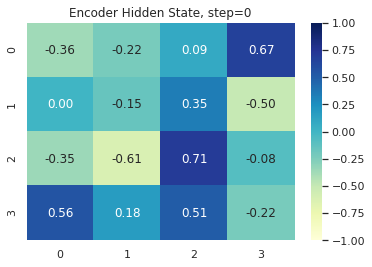

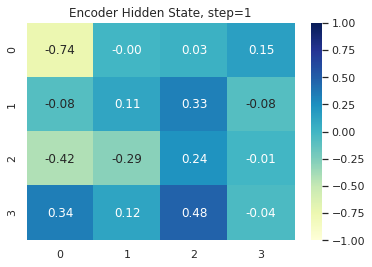

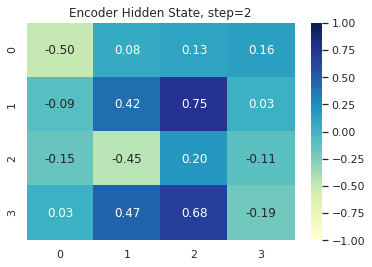

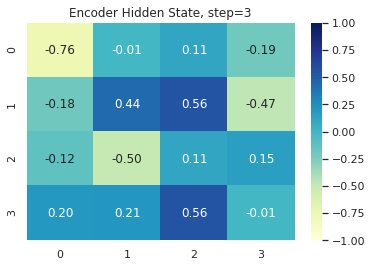

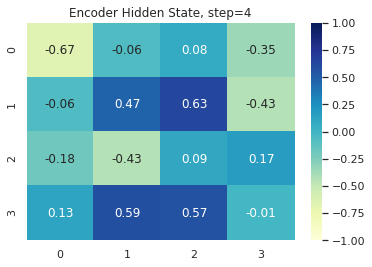

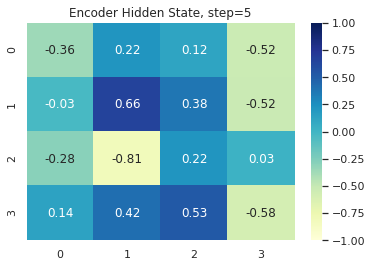

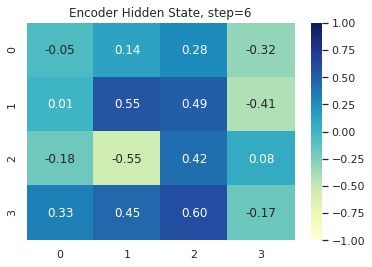

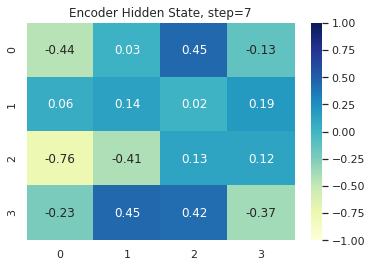

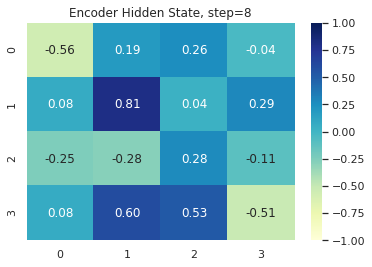

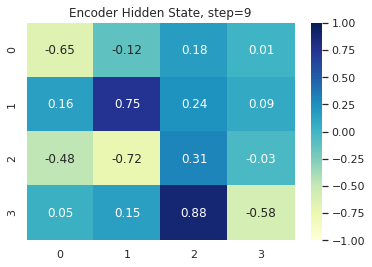

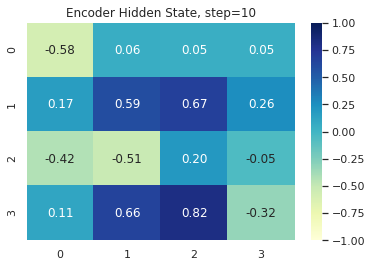

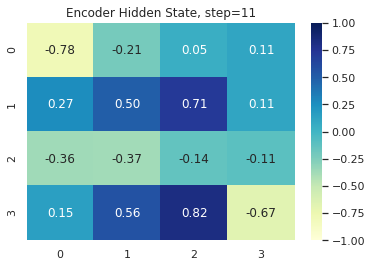

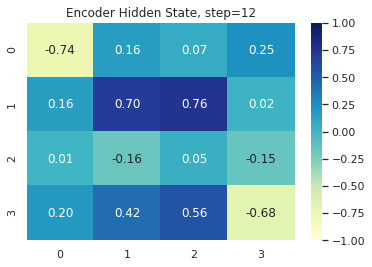

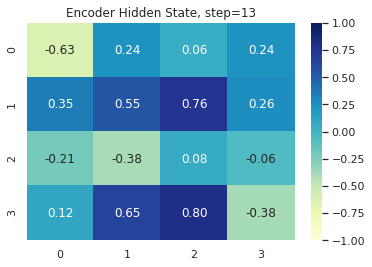

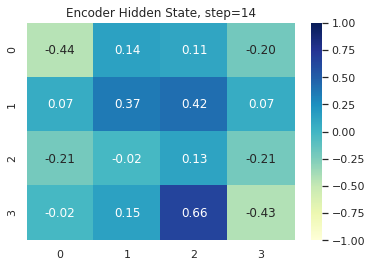

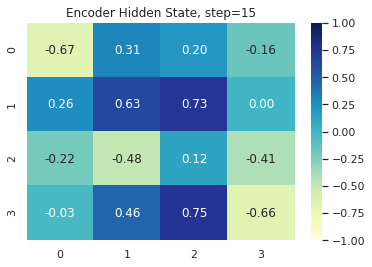

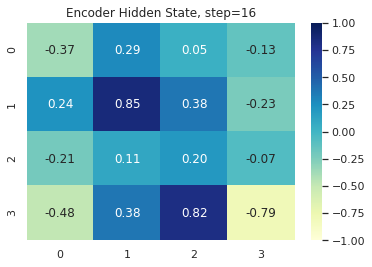

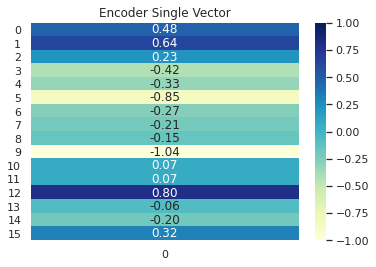

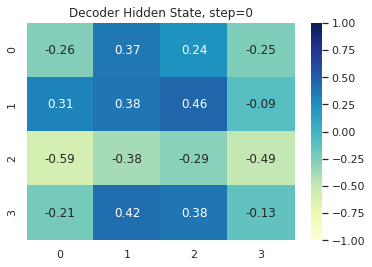

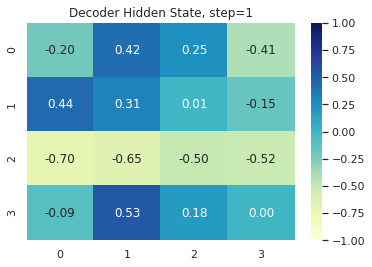

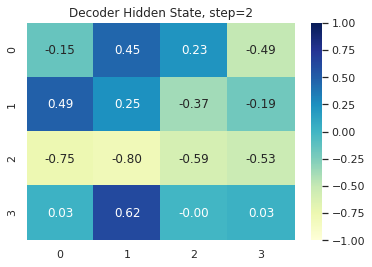

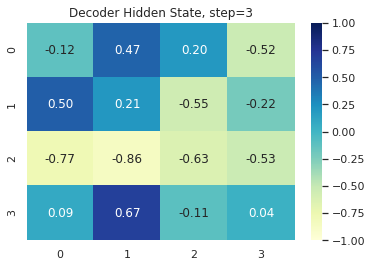

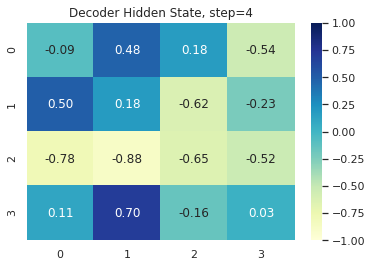

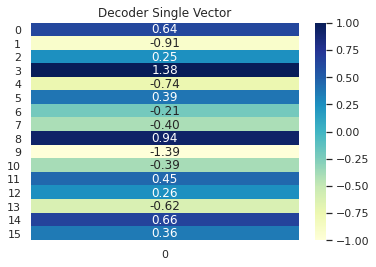

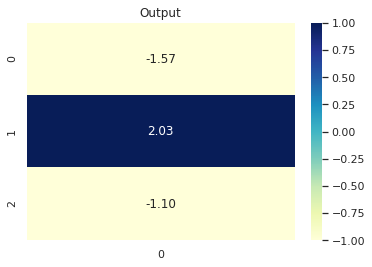

In [27]:
debug_model(tweet_model, tweet_dataset, debug_batch)

In [28]:
def get_misclassified(model, dataset):
    tweet = []
    tweet_cleaned = []
    label = []
    predicted = []

    loader = dataset.test_dataloader()

    for batch in iter(loader):
        labels, sequences, lengths, raw_text = batch
        with torch.no_grad():
            logits = tweet_model(sequences, lengths)
    
        pred = torch.argmax(F.log_softmax(logits, dim=1), dim=1)

        if (pred != labels):
            tweet.append(raw_text[0][0])
            tweet_cleaned.append(raw_text[0][1])
            label.append(dataset.get_labels()[labels[0]])
            predicted.append(dataset.get_labels()[pred[0]])
        
    return pd.DataFrame({
        'tweet': tweet,
        'tweet_cleaned': tweet_cleaned,
        'label': label,
        'predicted': predicted
    })

In [29]:
misclassified = get_misclassified(tweet_model, tweet_dataset)

In [30]:
for idx, row in list(misclassified.iterrows())[:5]:
    print(f"Tweet: {row['tweet']}\nTweet Cleaned: {row['tweet_cleaned']}\nLabel: {row['label']}\nPredicted: {row['predicted']}\n\n")

Tweet: Obama: Star Wars or Star Trek? - Movies News at IGN: http://t.co/HW7liQa9 via @IGN
Tweet Cleaned: Obama Star Wars or Star Trek? - Movies News at IGN via
Label: Neutral
Predicted: Negative


Tweet: I hope @PitchyPete uses this list to assign seats at his future dinner party. I want to talk fave TMNT w/ Obama & Oprah http://t.co/RoLLLTt2
Tweet Cleaned: I hope uses this list to assign seats at his future dinner party. I want to talk fave TMNT w/ Obama & Oprah
Label: Positive
Predicted: Negative


Tweet: RT @markknoller: Pres Obama slammed Romney for embracing a budget that supports a few doing well at the top, everyone else struggling to get by.
Tweet Cleaned:  Pres Obama slammed Romney for embracing a budget that supports a few doing well at the top, everyone else struggling to get by.
Label: Neutral
Predicted: Positive


Tweet: A couple of months ago Finnish officials found sixty of our Patriot missiles on a ship bound for China. Expect big Chicom donor$ to Obama
Tweet Cleaned: A

In [31]:
def get_correct_classified(model, dataset):
    tweet = []
    tweet_cleaned = []
    label = []
    predicted = []

    loader = dataset.test_dataloader()

    for batch in iter(loader):
        labels, sequences, lengths, raw_text = batch
        with torch.no_grad():
            logits = tweet_model(sequences, lengths)
    
        pred = torch.argmax(F.log_softmax(logits, dim=1), dim=1)

        if (pred == labels):
            tweet.append(raw_text[0][0])
            tweet_cleaned.append(raw_text[0][1])
            label.append(dataset.get_labels()[labels[0]])
            predicted.append(dataset.get_labels()[pred[0]])
        
    return pd.DataFrame({
        'tweet': tweet,
        'tweet_cleaned': tweet_cleaned,
        'label': label,
        'predicted': predicted
    })

In [32]:
correct_classified = get_correct_classified(tweet_model, tweet_dataset)

In [33]:
for idx, row in list(correct_classified.iterrows())[:5]:
    print(f"Tweet: {row['tweet']}\nTweet Cleaned: {row['tweet_cleaned']}\nLabel: {row['label']}\nPredicted: {row['predicted']}\n\n")

Tweet: Obama Respects the Supreme Court Says Eric Holder, Violence in Syria Continues in Anticipation of... http://t.co/5QBOVrBw #libertario #tlot
Tweet Cleaned: Obama Respects the Supreme Court Says Eric Holder, Violence in Syria Continues in Anticipation of...
Label: Positive
Predicted: Positive


Tweet: Pravda Endorses and Supports Obama   http://t.co/G68JEmkz
Tweet Cleaned: Pravda Endorses and Supports Obama
Label: Negative
Predicted: Negative


Tweet: RT @handrewschwartz: Ignatius reports Obama signaled Iran US wld accept civ nuke pgm if Khameni can assure Iran will never get nuke weapons http://t.co/KkaAhGPq
Tweet Cleaned:  Ignatius reports Obama signaled Iran US wld accept civ nuke pgm if Khameni can assure Iran will never get nuke weapons
Label: Positive
Predicted: Positive


Tweet: Talking about gas. Asked who is to blame. Tell him I can't narrow it to a single person. "First guy all week that didnt blame Obama!"
Tweet Cleaned: Talking about gas. Asked who is to blame. Tell hi